# Литература
* [Стратификация. Как разбиение выборки повышает чувствительность A/B теста](https://habr.com/ru/companies/X5Tech/articles/596279/)
* [Статья NETFLIX (eng)](https://www.researchgate.net/publication/305997925_Improving_the_Sensitivity_of_Online_Controlled_Experiments_Case_Studies_at_Netflix)

In [392]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats

sns.set_theme(context='notebook', 
                  style='darkgrid', 
                  palette='deep',
                  font='sans-serif', 
                  font_scale=1, 
                  color_codes=True, 
                  rc=None)

In [453]:
def generate_random_data(mean_one, mean_two, std_one, std_two, sample_size):
    '''
    Генерируется выборка размером sample_size со случайной долей страт

    Для простоты собирается выборка из двух нормальных распределений
    размера sample_size * 2, затем сэмплируется итоговая выборка 
    размера sample_size

    '''
    d_one = {'strat': 0,
             'metric': np.random.normal(loc=mean_one, scale=std_one, size=sample_size)}
    d_two = {'strat': 1,
             'metric': np.random.normal(loc=mean_two, scale=std_two, size=sample_size)}

    df_one = pd.DataFrame(d_one)
    df_two = pd.DataFrame(d_two)
    df = pd.concat([df_one, df_two], ignore_index=True).sample(sample_size)
    return df

In [454]:
def generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size):
    '''
    Генерируется выборка размером sample_size с постоянной долей страт

    Для простоты собирается выборка из двух нормальных распределений
    с долей страт 0.5/0.5

    '''
    size_strata_one = int(sample_size / 2)
    size_strata_two = sample_size - size_strata_one
    
    d_one = {'strat': 0,
             'metric': np.random.normal(loc=mean_one, scale=std_one, size=size_strata_one)}
    d_two = {'strat': 1,
             'metric': np.random.normal(loc=mean_two, scale=std_two, size=size_strata_two)}
    
    df_one = pd.DataFrame(d_one)
    df_two = pd.DataFrame(d_two)
    
    df = pd.concat([df_one, df_two], ignore_index=True)
    return df

In [472]:
def calculate_mean(df):
    return np.mean(df['metric'])

In [474]:
def calculate_stratified_mean(df, weights):
    pass

In [463]:
alpha = 0.05
sample_size = 1100
mean_one = 2000
mean_two = 3000
std_one = 625
std_two = 625

In [464]:
random_deltas = []
stratified_deltas = []
for _ in range(10000):
    a_one_random = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size) 
    a_two_random = generate_random_data(mean_one, mean_two, std_one, std_two, sample_size)
    random_deltas.append(np.mean(a_one_random['metric']) - np.mean(a_two_random['metric']))
    
    a_one_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size) 
    a_two_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size)
    stratified_deltas.append(np.mean(a_one_stratified['metric']) - np.mean(a_two_stratified['metric']))

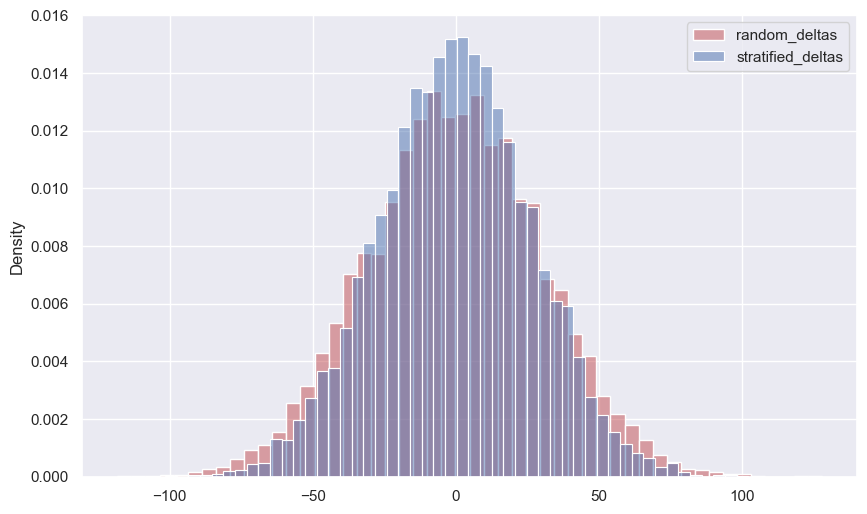

In [465]:
plt.figure(figsize=(10, 6))
sns.histplot(x=random_deltas, color="r", alpha=0.5, bins = 50, stat='density')
sns.histplot(x=stratified_deltas, color="b", alpha=0.5, bins = 50, stat='density')

plt.legend(labels=['random_deltas','stratified_deltas'])
plt.show()

In [470]:
random_means = []
stratified_means = []
weights = {0: 0.5, 1: 0.5}
for _ in range(10000):
    df_random =  generate_random_data(mean_one, mean_two, std_one, std_two, sample_size) 
    random_means.append(np.mean(df_random['metric']))
    
    df_stratified = generate_stratified_data(mean_one, mean_two, std_one, std_two, sample_size) 
    strat_mean = df_stratified.groupby('strat')['metric'].mean()
    
    df_means_weights = pd.merge(
                        strat_mean,
                        pd.Series(weights, name='weight'),
                        how='inner',
                        left_index=True,
                        right_index=True)
        
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
    stratified_means.append(mean_strat)

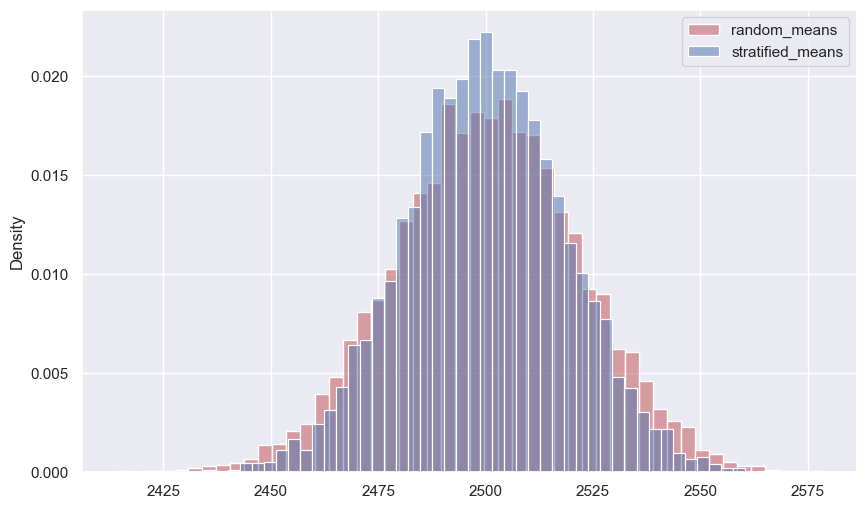

In [471]:
plt.figure(figsize=(10, 6))
sns.histplot(x=random_means, color="r", alpha=0.5, bins = 50, stat='density')
sns.histplot(x=stratified_means, color="b", alpha=0.5, bins = 50, stat='density')
plt.legend(labels=['random_means','stratified_means'])
plt.show()